# Coding Assignment Group i.) 1


This coding assignment tries to implement a approach to enhance class coloring visualizations through the application of weighted color intensity based on user-selectable metrics, including SDH, inverted U-Matrix, P-Matrix, and U*-Matrix. By transforming the class coloring into an HSV colorspace and adjusting the saturation channel according to the chosen weighting, the method offers a customizable parameter to modify the intensity of saturation decrease with decreasing weight.


In [1]:
import numpy as np
import os
from SOMToolBox_Parse import SOMToolBox_Parse
from minisom import MiniSom

## Datasets

In order to fulfill the given tasks stated in the assignment description we had to use two datasets. Once the chainlink dataset which represent artificial data of two rings in a 2D space which are being interwined in a 3D space. Second the 10 clusters dataset which simply includes datapoints of 10 different clusters which were generated from a gaussian distribution.

Therefore for each dataset we extracted the actual data (idata), the weights of the classes (weights) and the classes itself (classes). This was done using the SOMToolBoxParser in order to get the data in the right format and if necessary extract it.

As a 4th variable we chose a dimensions variable which includes the number of dimensions e.g. the amount of classes in a dataset.


In [2]:
dataset_str = "chainlink"

## Specify the vector and weight data to use for the following visualizations
idata_path_train = os.path.join("datasets", dataset_str, dataset_str + ".vec")
weights_path_train = os.path.join("datasets", dataset_str, dataset_str + ".wgt.gz")
classes_path_train = os.path.join("datasets", dataset_str, dataset_str + ".cls")

# Parse provided dataset files using the SOMToolbox Parser
idata_chainlink = SOMToolBox_Parse(idata_path_train).read_weight_file()
weights_chainlink = SOMToolBox_Parse(weights_path_train).read_weight_file()
classes_chainlink = SOMToolBox_Parse(classes_path_train).read_weight_file()

dim_chainlink = weights_chainlink['vec_dim']

dataset_str = "10clusters"

## Specify the vector and weight data to use for the following visualizations
idata_path_train = os.path.join("datasets", dataset_str, dataset_str + ".vec")
weights_path_train = os.path.join("datasets", dataset_str, dataset_str + ".wgt.gz")
classes_path_train = os.path.join("datasets", dataset_str, dataset_str + ".cls")

idata_10cluster = SOMToolBox_Parse(idata_path_train).read_weight_file()
weights_10cluster = SOMToolBox_Parse(weights_path_train).read_weight_file()
classes_10cluster = SOMToolBox_Parse(classes_path_train).read_weight_file()

dim_10cluster = weights_10cluster['vec_dim']

As for comparison reasons we also included the Iris-Datset in order to test our implemented code.

In [3]:
# Default Dataset

data_path = "datasets\\iris\\iris.vec"
weight_path = "datasets\\iris\\iris.wgt.gz"

data_path_ch = "datasets\\chainlink\\chainlink.vec"
weight_path_ch = "datasets\\chainlink\\chainlink.wgt.gz"

idata = SOMToolBox_Parse(data_path).read_weight_file()
weights = SOMToolBox_Parse(weight_path).read_weight_file()
classes = SOMToolBox_Parse("datasets\\iris\\iris.cls").read_weight_file()

idata_ch = SOMToolBox_Parse(data_path_ch).read_weight_file()
weights_ch = SOMToolBox_Parse(weight_path_ch).read_weight_file()
classes_ch = SOMToolBox_Parse("datasets\\chainlink\\chainlink.cls").read_weight_file()

## Matrices for saturation

For generating weights we had to use four different approaches. The U-Matrix, The P-Matrix, The Smoothed Data Histogram and the U-Star-Matrix. The functions below are showing the implementations of those. 

In [4]:
#HitHistogram
def HitHist(_m, _n, _weights,_idata):
    hist = np.zeros(_m * _n)
    for vector in _idata: 
        position =np.argmin(np.sqrt(np.sum(np.power(_weights - vector, 2), axis=1)))
        hist[position] += 1

    return hist.reshape(_m, _n)

#U-Matrix - implementation
def UMatrix(_m, _n, _weights, _dim):
    U = _weights.reshape(_m, _n, _dim)
    U = np.insert(U, np.arange(1, _n), values=0, axis=1)
    U = np.insert(U, np.arange(1, _m), values=0, axis=0)
    #calculate interpolation
    for i in range(U.shape[0]): 
        if i%2==0:
            for j in range(1,U.shape[1],2):
                U[i,j][0] = np.linalg.norm(U[i,j-1] - U[i,j+1], axis=-1)
        else:
            for j in range(U.shape[1]):
                if j%2==0: 
                    U[i,j][0] = np.linalg.norm(U[i-1,j] - U[i+1,j], axis=-1)
                else:      
                    U[i,j][0] = (np.linalg.norm(U[i-1,j-1] - U[i+1,j+1], axis=-1) + np.linalg.norm(U[i+1,j-1] - U[i-1,j+1], axis=-1))/(2*np.sqrt(2))

    U = np.sum(U, axis=2) #move from Vector to Scalar

    for i in range(0, U.shape[0], 2): #count new values
        for j in range(0, U.shape[1], 2):
            region = []
            if j>0: region.append(U[i][j-1]) #check left border
            if i>0: region.append(U[i-1][j]) #check bottom
            if j<U.shape[1]-1: region.append(U[i][j+1]) #check right border
            if i<U.shape[0]-1: region.append(U[i+1][j]) #check upper border

            U[i,j] = np.median(region)

    return U

#SDH - implementation
def SDH(_m, _n, _weights,_idata, factor, approach):
    import heapq

    sdh_m = np.zeros( _m * _n)

    cs=0
    for i in range(factor): cs += factor-i

    for vector in _idata:
        dist = np.sqrt(np.sum(np.power(_weights - vector, 2), axis=1))
        c = heapq.nsmallest(factor, range(len(dist)), key=dist.__getitem__)
        if (approach==0): # normalized
            for j in range(factor):  sdh_m[c[j]] += (factor-j)/cs 
        if (approach==1):# based on distance
            for j in range(factor): sdh_m[c[j]] += 1.0/dist[c[j]] 
        if (approach==2): 
            dmin, dmax = min(dist[c]), max(dist[c])
            for j in range(factor): sdh_m[c[j]] += 1.0 - (dist[c[j]]-dmin)/(dmax-dmin)

    return sdh_m.reshape(_m, _n)

def PMatrix(_m, _n, _weights, _idata, _radius):
    distance = lambda v: np.sum(np.linalg.norm(_idata[:, None, :] - v, axis=-1) < _radius)
    plot = np.array([distance(v) for v in _weights])
    pm = plot.reshape(_m, _n)  # Reshape according to your matrix dimensions
    return pm

def UStarMatrix(_m, _n, _weights,_idata, _dim, _radius):
    um = UMatrix(_m, _n, _weights, _dim)
    pm = PMatrix(_m, _n, _weights,_idata, _radius)
    um = um[0::2,0::2].reshape(1,-1)[0] # u-matrix
    pm = pm.reshape(1,-1)[0]   # p-matrix
    ustarm = []
    
    meanP = np.mean(pm)
    maxP  = np.max(pm)
    diff = meanP - maxP
    
    n = pm.size
    for i in range(n):
        scaleFactor = (pm[i] - meanP) / diff + 1
        ustarm.append(um[i] * scaleFactor)
    plot = np.array(ustarm)
    ustart = plot.reshape(_m, _n)
    return ustart

### Visualization for saturation matrices

The following plots are visualizations of the above created functions. Those were necessary in order to determine if our functions are working properly. The functions were tested via the Iris-Dataset and compared to the images of the "PySOMViS-Repository" on GitHub. 

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
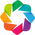

:Layout
   .Image.U_hyphen_minus_Matrix     :Image   [x,y]   (z)
   .Image.SDH                       :Image   [x,y]   (z)
   .Image.P_hyphen_minus_Matrix     :Image   [x,y]   (z)
   .Image.UStar_hyphen_minus_Matrix :Image   [x,y]   (z)

In [5]:
import holoviews as hv
hv.extension('bokeh')
um = hv.Image(UMatrix(weights['ydim'], weights['ydim'], weights['arr'], 4)).opts(xaxis=None, yaxis=None) 
sdh = hv.Image(SDH(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'], 25, 0)).opts(xaxis=None, yaxis=None)
pm = hv.Image(PMatrix(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'], 1.2)).opts(xaxis=None, yaxis=None)
usm = hv.Image(UStarMatrix(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'], 4, 1.2)).opts(xaxis=None, yaxis=None)

hv.Layout([um.relabel('U-Matrix').opts(cmap='jet'), sdh.relabel('SDH').opts(cmap='viridis'),pm.relabel('P-Matrix').opts(cmap='jet'),usm.relabel('UStar-Matrix').opts(cmap='jet')])

## Own Implementations (Chessboard with saturation)

This chapter represents the actual task. First, we took the existing Chessboard-Implementation of the PySOMVis Repository and changed it from a Class-Implementation to a function based one. After adapting every variable and changing the formating of the code we were able to run the function as a standalone. 

Next, we 

In [6]:
from scipy.spatial import Voronoi
from skimage.draw import polygon
from skimage.color import rgb2hsv, hsv2rgb
from holoviews.streams import Pipe
import matplotlib.pyplot as plt
import math

_pipe = Pipe(data=[])
_pipe_points = Pipe(data=[])
_pipe_paths = Pipe(data=[])

def dist_point_to_segment(pixels, s0, s1=None):
	"""
	Get the distance of a point to a segment or point.
		*p*, *s0*, *s1* are *xy* sequences
	This algorithm is from http://geomalgorithms.com/a02-_lines.html
	"""
	distances = []
	if s1 is None: #distance between points and point
		distances = np.linalg.norm(pixels[:, None, :] - s0, axis=-1)
	else:          #distance between point and line segment
		dist = lambda x,y: round(np.linalg.norm(x-y),1)
		for p in pixels:        
			v,   w = s1 - s0, p - s0
			c1, c2 = np.dot(w, v), np.dot(v, v)
			b = c1 / c2
			pb = s0 + b * v
			if c1 <= 0:    distances.append(dist(p,s0))
			elif c2 <= c1: distances.append(dist(p,s1))
			else:          distances.append(dist(p,pb))
	distances = np.column_stack((pixels,distances))
	distances = distances[distances[:, -1].argsort()] #sort distances
	return distances[:,0:2].astype(int)

def check_polygon_intersection(polygons, get_vertices):
	"""
	Return shared vertex between polygons
	"""
	for i in range(len(polygons)):
		for j in range(i+1,len(polygons)): 
			poly1 = get_vertices(polygons[i])
			poly2 = get_vertices(polygons[j])
			shared_vertex = np.intersect1d(poly1, poly2)
			if shared_vertex.size==1: return (shared_vertex, poly1, poly2)
	return None

def _interpolation(interpolation):
        if interpolation:
            _pipe.send(resize(_pipe.data, (1000, 1000)))

def convert_to_xy(_m, _n, neuron=None, point2D=None):
        scale = lambda a,b,x,minx,maxx: (b-a)*((x-minx)/(maxx-minx))+a  # adjust to -0.5 to 0.5 because of holoviews Image
        y, x = 0, 0
        if neuron is not None:   y, x = np.unravel_index(neuron, (_m, _n))
        if point2D is not None:  y, x = point2D[1], point2D[0]
        y = scale(-0.5, 0.5, y, -0.5, _m-0.5)
        x = scale(-0.5, 0.5, x, -0.5, _n-0.5)
        return x, -1*y

def display(_m, _n, plot=None, paths=None, points=None, interpolation=False):
        if plot is not None: 
            if _m==1:  plot = np.vstack([plot, plot])  # hv.Image doesn't work with one line input
            if _n==1:  plot = np.c_[plot, plot]        # hv.Image doesn't work with one line input
            if interpolation: plot = resize(plot, (1000, 1000))
            _pipe.send(plot)
        if paths is not None:
            _pipe_paths.send(paths)
        if points is not None:
            _pipe_points.send(points)

def Chessboard(_m, _n, _weights, _idata, _classes, _dim, _dpi, _voronoi_lines, _chessboard, interpolation, saturationIntensity, matrix):
	classes = [0] * (_m * _n)
	grid = _m * _n
	n_classes = np.unique(_classes).tolist()
	mapped_data = np.zeros(grid * len(n_classes), dtype=int).reshape(grid,-1)

	bmu = np.apply_along_axis(lambda x: np.argmin( np.linalg.norm(
		_weights - x.reshape((1, _dim)), axis=1)), 1,_idata)

	for i in range(len(_classes)):
		c = n_classes.index(_classes[i])
		u = bmu[i]
		mapped_data[u][c] += 1

	vpoints = []
	dummy=[]
	# position becomes a vpoint if it has a non-empty class array
	for position, v in enumerate(mapped_data):
		if sum(v) > 0:
			x,y = position % _n, position // _n
			vpoints.append([x, y])

		    #dummy vetices for finit polygons
			if x == 0:                        	  dummy.append([-1, y])
			if x == _n-1:              dummy.append([_n, y])
			if y == 0:                            dummy.append([x, -1])
			if y == _m-1:              dummy.append([x, _m])
			if x == 0 and y == 0:                 dummy.append([-1, -1])
			if x == _n-1 and y == _m-1: 
				dummy.append([_n, _m])    
			if x == _n-1 and y == 0:   dummy.append([_n, -1])
			if x == 0 and y == _m-1:   dummy.append([-1, _m])
		            
	mapped_data = mapped_data[~np.all(mapped_data == 0, axis=1)]
	vpoints = dummy + vpoints

	# compute Voronoi tesselation
	vdiagram = Voronoi(vpoints)
	vdiagram.close() #release memory

	dpi = 100 if _dpi else 10

	get_vertices = lambda x: vdiagram.regions[vdiagram.point_region[x]]
	get_coordinates = lambda x: (vdiagram.vertices[x]+0.5)*dpi
	plot = np.zeros((_n*dpi, _m*dpi), dtype=int)

	for position in range(len(dummy), len(vpoints)):
		polygon_cur = get_vertices(position)
		poly = get_coordinates(polygon_cur)
		rr, cc = polygon(poly[:,0], poly[:,1])
		    
		#sometimes it is needed :) 
		rr = rr[cc<plot.shape[1]]
		cc = cc[cc<plot.shape[1]]
		cc = cc[rr<plot.shape[0]]
		rr = rr[rr<plot.shape[0]]
		#end

		colors = mapped_data[position-len(dummy)]
		perc = np.round(colors/np.linalg.norm(colors,1.0), 3) # percentages (ratios) array
		dominant_color = np.argmax(colors)
		colors_ind = np.nonzero(mapped_data[position-len(dummy)])[0]
		plot[rr,cc] = dominant_color
		colors_ind = colors_ind[colors_ind!=dominant_color] #we don't need dominant color any more
		if len(colors_ind) > 0:
			pixels = np.column_stack((rr,cc))
			total_pixels = len(pixels)
			centroid = pixels.mean(0) #get center of the current region

			if _chessboard:
				np.random.shuffle(pixels)
				chunks = np.split(pixels, (len(pixels)*perc[:-1].cumsum()).astype(int)) #split pixels accordingly percentages
				for c, pixels  in enumerate(chunks):
					plot[pixels[:,0],pixels[:,1]] = c 
			else:
		        #find neighbours of current polygon
				neighbours = vdiagram.ridge_points[(vdiagram.ridge_points==position).any(axis=1) 
					                                & (vdiagram.ridge_points>=len(dummy)).all(axis=1)]
				neighbours = neighbours[neighbours!=position].flatten() #remove the current region form neighb					
				#get colors of all neighbors
				neighbours_colors = np.insert(mapped_data[neighbours-len(dummy)], mapped_data.shape[1], neighbours, axis=1)
		            
				for c in colors_ind: #go over all colors of polygon
					pixels = pixels[plot[pixels[:,0],pixels[:,1]] == dominant_color] #we can change only pixels colored in dominant color
					point1, point2 = None, None

					nc = neighbours_colors[neighbours_colors[:,c]>0] #check how many neighbours have the same colour
					if   len(nc)==0: point1, point2 = centroid, None # color is isolated, no neighbours with the same color
					elif len(nc)==1: # there is only one neighbour with the same color
						neighbour = get_vertices(nc[:,-1][0])
						adjacent_border = get_coordinates(np.intersect1d(polygon_cur, neighbour))

						#check if neighbor has only dominant color
						if (nc[nc>0].size-1==1): point1, point2 = adjacent_border[1], adjacent_border[0] #if this color is dominant color for neighbor - consider adjacent border
						else:                    point1, point2 = centroid, adjacent_border.mean(0)      #else consider line segment from center to border
		                        
					elif len(nc)>1: #if we have a set of neighbours with the same color
		                   
						dominant = []
						not_dominant = []
						for n in nc: #divide set on dominant and not
							if n[n>0].size-1==1: dominant.append(n[-1])
							else:                not_dominant.append(n[-1])
		                    
						if len(dominant)>0: #consider dominant color of neighbors - first
							intersection = check_polygon_intersection(dominant, get_vertices)
							if intersection is not None: #check iintersection of neighbors with the same color
								point1, point2 = get_coordinates(intersection[0]), None
							else:
								neighbour = get_vertices(dominant[0]) # no intersection - take first neighbour
								adjacent_border = get_coordinates(np.intersect1d(polygon_cur, neighbour))
								point1, point2 = adjacent_border[0], adjacent_border[1]                      
						else: #same for neighbours which have the same color but not dominant
							intersection = check_polygon_intersection(not_dominant, get_vertices)
							if intersection is not None:
								point1 = get_coordinates(np.intersect1d(intersection[1],polygon_cur)).mean(0)
								point2 = get_coordinates(np.intersect1d(intersection[2],polygon_cur)).mean(0)
							else:
								neighbour1 = get_vertices(not_dominant[0])
								neighbour2 = get_vertices(not_dominant[-1])
								point1 = get_coordinates(np.intersect1d(neighbour1,polygon_cur)).mean(0)
								point2 = get_coordinates(np.intersect1d(neighbour2,polygon_cur)).mean(0)
		                    
					sorted_pixels = dist_point_to_segment(pixels, point1, point2)
		                                
					N = round(total_pixels*perc[c]) #get number of pixels accordying to the percentge
					plot[sorted_pixels[0:N,0],sorted_pixels[0:N,1]] = c #cahnge pixel color
		
	paths = []
	if _voronoi_lines:
		for v in vdiagram.ridge_vertices:
			if -1 not in v:
				p1 = list(convert_to_xy(point2D=vdiagram.vertices[v[0]]))
				p2 = list(convert_to_xy(point2D=vdiagram.vertices[v[1]]))
				paths.append(tuple(p1)+tuple(p2))

	plot = np.flipud(np.rot90(plot, k=-1, axes=(1,0)))
	display(_m, _n, plot=plot, paths=paths, interpolation=interpolation)


	# Selecting a color sheme for the chessboard implementation (used-one: jet)
	cmap = plt.cm.get_cmap('jet', np.max(plot) + 1) 

	# Map the integer values to RGB colors
	rgb_image = cmap(plot)
	# Remove the alpha channel
	rgb_image = rgb_image[:, :, :3]
	# Transforming the RGB image to HSV
	hsv_im = rgb2hsv(rgb_image)

	# User selectable weighting factors (UMatrix, SDH, PMatrix, UStarMatrix)
	if matrix == "UMatrix":
		weights_u = UMatrix(weights['ydim'], weights['ydim'], weights['arr'], 4)
	elif matrix == "SDH":
		weights_u = SDH(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'], 25, 0)
	elif matrix == "PMatrix":
		weights_u = PMatrix(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'], 1.014889156509222)
	elif matrix == "UStarMatrix":
		weights_u = UStarMatrix(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'], 4, 1.014889156509222)
	else:
		# As a default we chose to use the UMatrix with a saturation intensity of 0
		# simply means no weights are applied to the saturation
		weights_u = UMatrix(weights['ydim'], weights['ydim'], weights['arr'], 4)
		saturationIntensity = 0
	
	# Normalizing the weights
	weights_u = (weights_u - weights_u.min()) / (weights_u.max() - weights_u.min())
		
	# Dimension Convertion
	# Dimensions_big represent the dimensions of the 100 x 60 SOMs (or bigger ones where x_dim & y_dim are not equal)
	# Dimensions_small represent the dimensions of the 10 x 10 SOMs (or smaller ones where x_dim & y_dim are equal)

	dimensions_big_x = hsv_im.shape[0]
	dimensions_small_x = weights_u.shape[0]

	dimensions_big_y = hsv_im.shape[1]
	dimensions_small_y = weights_u.shape[1]

	# TODO
	dimensions_small_x = math.ceil(dimensions_big_x / dimensions_small_x)
	dimensions_small_y = math.ceil(dimensions_big_y / dimensions_small_y)

	# Applying the weights to the saturation
	for i in range(0, dimensions_big_x):
		for j in range(0, dimensions_big_y):
			if i == 0 and j == 0:
				hsv_im[0, 0, 1] = hsv_im[0, 0, 1] + (hsv_im[0, 0, 1] * (weights_u[0, 0] - 1) * saturationIntensity)
			elif i == 0:
				hsv_im[0, j, 1] = hsv_im[0, j, 1] + (hsv_im[0, j, 1] * (weights_u[0, j // dimensions_small_y] - 1) * saturationIntensity)
			elif j == 0:
				hsv_im[i, 0, 1] = hsv_im[i, 0, 1] + (hsv_im[i, 0, 1] * (weights_u[i // dimensions_small_x, 0] - 1) * saturationIntensity)
			else:
				hsv_im[i, j, 1] = hsv_im[i, j, 1] + (hsv_im[i, j, 1] * (weights_u[i // dimensions_small_x, j // dimensions_small_y] - 1) * saturationIntensity)
	
	# Transforming the HSV image back to RGB (in order to get an actual image)
	rgb_image_new = hsv2rgb(hsv_im)	
	
	# Displaying the image
	plt.imshow(rgb_image_new)
	plt.axis('off')
	plt.show()

### Testing function with IRIS

C:\Users\a872460\AppData\Local\Temp\ipykernel_26660\1825303997.py:212: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', np.max(plot) + 1)  # You can choose a different colormap


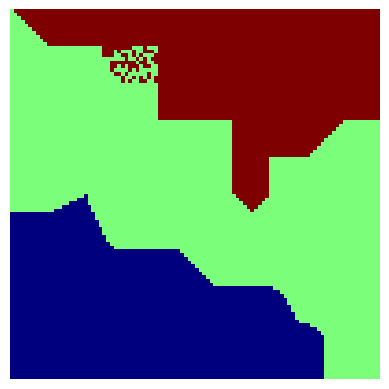

In [7]:
interpolation = False
chessboard = True
high_dpi = False
voronoi = False
saturationIntensity = 0.8
matrix = ["default","UMatrix","PMatrix","SDH","UStarMatrix"]

c = Chessboard(weights['ydim'], weights['ydim'], weights['arr'], idata['arr'], classes['arr'][:,1], 4, 
               high_dpi, voronoi, chessboard, interpolation, saturationIntensity, matrix[0])

## Dataset 1: Chainlink

### Trained SOM's

In [8]:
som_small = MiniSom(10, 10, dim_chainlink)
som_small.train(idata_chainlink['arr'], 100_000)

#som_medium = MiniSom(18, 12, dim_train, sigma=1.5)
#som_medium.train(idata_train['arr'], 10000)

som_large = MiniSom(100, 60, dim_chainlink)
som_large.train(idata_chainlink['arr'], 10_000)

### Small (10x10)

C:\Users\a872460\AppData\Local\Temp\ipykernel_26660\1825303997.py:212: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', np.max(plot) + 1)  # You can choose a different colormap


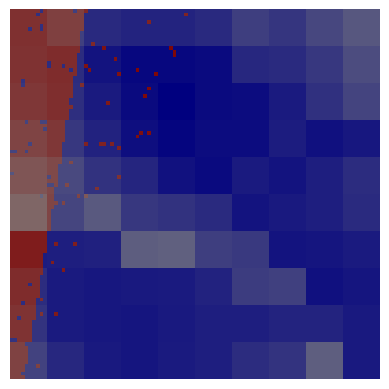

In [9]:
c = Chessboard(10, 10, som_small._weights, idata_chainlink['arr'], classes_chainlink['arr'][:,1], 
               dim_chainlink, high_dpi, voronoi, chessboard, interpolation, saturationIntensity, matrix[2])

#c = Chessboard(18, 12, som_medium._weights, idata_train['arr'], classes_train['arr'][:,1], 
                #dim_train, high_dpi, voronoi, chessboard, interpolation, saturationIntensity, matrix[2])


#c = Chessboard(weights_train["ydim"], weights_train["ydim"], weights_train["arr"], idata_train['arr'], 
#               classes_train['arr'][:,1], dim_train, high_dpi, voronoi, chessboard, interpolation, saturationIntensity, matrix[2])

### Large (100x60)

C:\Users\a872460\AppData\Local\Temp\ipykernel_26660\1825303997.py:212: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', np.max(plot) + 1)  # You can choose a different colormap


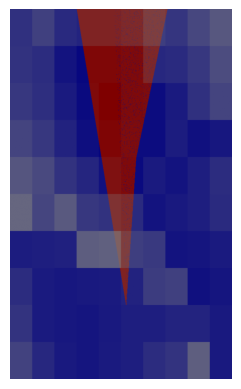

In [10]:
c = Chessboard(100, 60, som_large._weights, idata_chainlink['arr'], classes_chainlink['arr'][:,1], 
               dim_chainlink, high_dpi, voronoi, chessboard, interpolation, saturationIntensity, matrix[2])

In [11]:
'''
for i in np.arange(0.1,2,0.1):
    for j in np.arange(0.5,7,0.5):
        if i == 0.3:
            continue
        print("\n learning rate ",i,"sigma ",j)
        try:
            som_small = MiniSom(10, 10, dim_chainlink, learning_rate=i, sigma=j)
            som_small.train(idata_chainlink['arr'], 100000)
            c = Chessboard(10, 10, som_small._weights, idata_chainlink['arr'], classes_chainlink['arr'][:,1], dim_chainlink, high_dpi, voronoi, chessboard, interpolation, saturationIntensity, matrix[2])
        except Exception as e:
            print(e)
            continue
'''

'\nfor i in np.arange(0.1,2,0.1):\n    for j in np.arange(0.5,7,0.5):\n        if i == 0.3:\n            continue\n        print("\n learning rate ",i,"sigma ",j)\n        try:\n            som_small = MiniSom(10, 10, dim_chainlink, learning_rate=i, sigma=j)\n            som_small.train(idata_chainlink[\'arr\'], 100000)\n            c = Chessboard(10, 10, som_small._weights, idata_chainlink[\'arr\'], classes_chainlink[\'arr\'][:,1], dim_chainlink, high_dpi, voronoi, chessboard, interpolation, saturationIntensity, matrix[2])\n        except Exception as e:\n            print(e)\n            continue\n'

## Dataset 2: 10clusters

### Trained SOM's

In [12]:
som_small = MiniSom(10, 10, dim_10cluster)
som_small.train(idata_10cluster['arr'], 100_000)

#som_medium = MiniSom(18, 12, dim_train, sigma=1.5)
#som_medium.train(idata_train['arr'], 10000)

som_large = MiniSom(100, 60, dim_10cluster)
som_large.train(idata_10cluster['arr'], 10_000)

### Small (10x10)

C:\Users\a872460\AppData\Local\Temp\ipykernel_26660\1825303997.py:212: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', np.max(plot) + 1)  # You can choose a different colormap


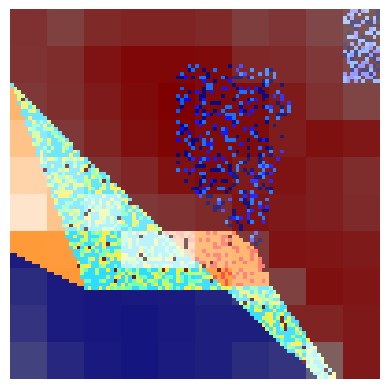

In [13]:
c = Chessboard(10, 10, som_small._weights, idata_10cluster['arr'], classes_10cluster['arr'][:,1], 
               dim_10cluster, high_dpi, voronoi, chessboard, interpolation, saturationIntensity, matrix[2])

### Large (100x60)

C:\Users\a872460\AppData\Local\Temp\ipykernel_26660\1825303997.py:212: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', np.max(plot) + 1)  # You can choose a different colormap


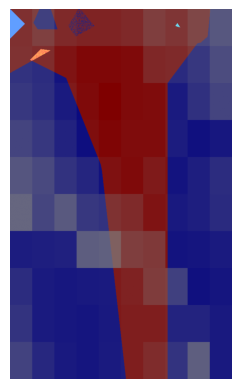

In [14]:
c = Chessboard(100, 60, som_large._weights, idata_10cluster['arr'], classes_10cluster['arr'][:,1], 
               dim_10cluster, high_dpi, voronoi, chessboard, interpolation, saturationIntensity, matrix[2])